# Neural Networks

A neural network is a Machine Learning model (very loosely) based on a model of how neuron works. The idea is as follows: a neuron gathers information from the preceding neurons through its dendrites, it processes it and passes the processed information to the following neurons via the axon. As a first approximation, we can understand the processing as an activation: the neuron only activates and passes the message if it is above some threshold.

## Architecture: the Multi-Layer Perceptron (MLP)

A MLP defines a non-linear $\mathbb{R}^{N_1}\to\mathbb{R}^{N_L}$ function (usually with $N_L=1$), that in principle can reproduce any arbitrary function [NOTE: Usually we will work with NNs defined in $[0,1]^{N_1}\to[0,1]^{N_L}$, but this is simply a rescaling of the inputs and outputs]. In a MLP, the neurons are grouped in $L$ layers, each layer containing $N_L$ neurons. The neurons of layer $i$ can only receive data from layer $i-1$. The first layer corresponds to the input, the last layer to the output, and any other layer is called "hidden layer". A network with more than one hidden layer is called a deep network.

![Alt text](mlp.png)

In a MLP each neuron of layer $i$ receives information from ALL neurons of layer $i-1$ with different weights $w^{(i)}_{jk}$ and a bias $b^{(i)}_j$,
$$y^{(i)}_j = b^{(i)}_j + \sum_k w^{(i)}_{jk} x^{(i-1)}_k$$
and then it applies a non-linear activation function $f: \mathbb{R} \to \mathbb{R}$,
$$x^{(i)}_j = f(y^{(i)}_j) = f\left(b^{(i)}_j + \sum_k w^{(i)}_{jk} x^{(i-1)}_k\right)$$

## Choice of the Activation function

The activation function is what gives the neural network the ability of reproducing any arbitrary function. Note that if we chose $f$ as the identity function, the neural network would be reduced to a simple linear regression, which can not capture most functions.

The simplest activation function id the Heaviside $\Theta$, also known in the ML circles as perceptron (hence the name Multi-Layer Perceptron). However, perceptrons aren't used nowadays.

### Sigmoids

Sigmoids are a class of functions $f(y)$ that tend asymptotically to constant values when $y\to\pm\infty$, but that have a smooth behavior in the intermediate region, which is important for the numerical stability of the NN. The two sigmoids used are:
* The hyperbolic tangent $f(y) = \mathrm{tanh}(y)$, with $\lim_{y\to\pm\infty}\mathrm{tanh}(y) = \pm 1$ and $\mathrm{tanh}(0) = 0$.
* The logistic function $$f(y) = \frac{1}{1+e^{-y}}$$ with $\lim_{y\to-\infty}f(y) = 0$, $\lim_{y\to+\infty}f(y) = 1$ and $f(0) = 1/2$.

In fact, the logistic function is just a re-scaled hyperbolic tangent,
$$\mathrm{tanh}(y) = \frac{e^y-e^{-y}}{e^y + e^{-y}} = \frac{1-e^{-2y}}{1+e^{-2y}} = \frac{2}{1+e^{-2y}} -1$$

The sigmoid functions have the problem that their gradient is usually a small value, which will lead to slow training of the network.

### ReLU

The ReLU function or ramp is activated only for positive inputs, $$f(y) = \mathrm{max}(0, y) = \left\{\begin{matrix} y & y>0 \\ 0 & y\leq 0 \end{matrix} \right.$$

This function reduces the problem of the vanishing gradient compared to the sigmoids because the function only saturates in one direction instead of both directions. The problem can be further mitigated with a Leaky ReLU, $$f(y) =  \left\{\begin{matrix} y & y>0 \\ 0.01y & y\leq 0 \end{matrix} \right.$$
which allows non-zero gradients for all the range of $y$.

In [1]:
import numpy as np  
import matplotlib.pyplot as plt

In [2]:
y = np.linspace(-5, 5, 300)

In [3]:
perceptron = lambda y: np.array([int(yi > 0) for yi in y])
logistic = lambda y: 1/(1+np.exp(-y))
relu = lambda y: np.array([yi*int(yi>0) for yi in y])
leaky = lambda y: np.array([0.01*yi+0.99*yi*int(yi>0) for yi in y])

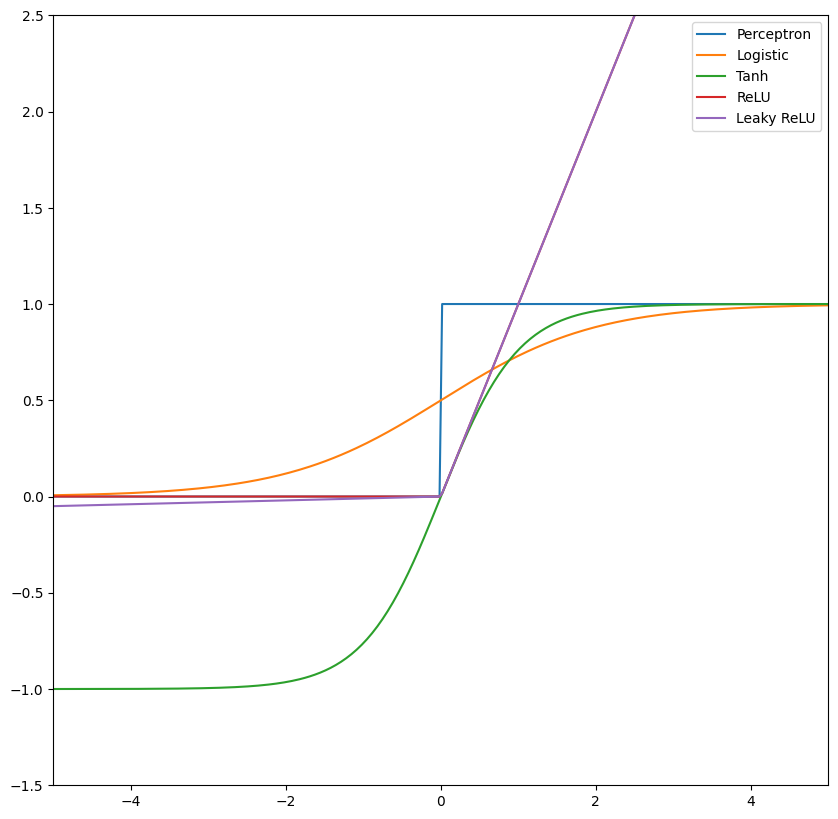

In [4]:
plt.figure(figsize=(10,10))
plt.plot(y, perceptron(y), label='Perceptron')
plt.plot(y, logistic(y), label='Logistic')
plt.plot(y, np.tanh(y), label='Tanh')
plt.plot(y, relu(y), label='ReLU')
plt.plot(y, leaky(y), label='Leaky ReLU')
plt.xlim(-5,5)
plt.ylim(-1.5, 2.5)
plt.legend()

## Learning

Now that we have decided the characteristics of the NN, we have to determine the weights and biases. This is done through supervised learning. We need a set of inputs $\{X_1, \ldots X_M\}$ with $X_i \in \mathbb{R}^{N_1}$ and their corresponding true outputs $\{Y_1, \ldots Y_M\}$ with $Y_i \in \mathbb{R}^{N_L}$

### Cost function

The cost function gives a quantitative account of the degree of agreement between the real output $\{Y^1, \ldots Y^M\}$ and the output generated by the NN, $\{\hat{Y}^1, \ldots \hat{Y}^M\}$, where $\hat{Y}^n = (x^{(L)}_1(X_n), x^{(L)}_2(X_n), \ldots, x^{(L)}_{N_L}(X_n))$. We will define individual cost functions $\mathcal{C}(X_n, Y_n; \{w, b\})$ for each data point, and the total cost function as their average, $$\mathcal{C}(\{w, b\}) = \frac{1}{M}\sum_{n=1}^M \mathcal{C}(X_n, Y_n; \{w, b\})$$

* Mean sqaured error: $$\mathcal{C}(X_n, Y_n; \{w, b\}) = \frac{1}{2} || Y^n - \hat{Y}^n ||^2 = \frac{1}{2} \sum_{j=1}^{N_L} [Y_j^n - \hat{Y}_j^n]^2$$
* Cross-entropy: $$\mathcal{C}(X_n, Y_n; \{w, b\}) = - \sum_{j=1}^{N_L}[Y^n_j \ln \hat{Y}^n_j+(1-Y^n_j)\ln(1-\hat{Y}^n_j)]$$
* Kullback-Leibler (KL) divergence: the output must be in $[0,1]^{N_L}$ $$\mathcal{C}(X_n, Y_n; \{w, b\}) = \sum_{j=1}^{N_L} Y_j^n \ln \frac{Y_j^n}{\hat{Y}_j^n}$$

### Minimization

The minimization of the cost function with respect to the NN parameters is performed via gradient descent. The idea is that the fastest way to reach a minimum is to travel in the direction of steepest slope. With each data of the dataset we will update the weights and biases according to

$$\Delta w_{jk}^{(i)} = -\eta \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial w_{jk}^{(i)}}\qquad\qquad\Delta b_j^{(i)} = -\eta \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial b_j^{(i)}}$$
where $\eta$ is the training rate, that we will have to choose so the learning process converges quickly but without overshooting.

Let's calculate the gradients for the last layer using the chain rule:

$$\frac{\partial \mathcal{C}(X_n, Y_n)}{\partial w_{jk}^{(L)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(L)}} \frac{\partial x_j^{(L)}}{\partial y_j^{(L)}} \frac{\partial y_j^{(L)}}{\partial w_{jk}^{(L)}} = [\nabla \mathcal{C}(X_n, Y_n)]_j \cdot f'(x_k^{(L-1)}) \cdot x_k^{(L-1)} \equiv \delta_j^{(L)} x_k^{(L-1)}$$
$$\frac{\partial \mathcal{C}(X_n, Y_n)}{\partial b_j^{(L)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(L)}} \frac{\partial x_j^{(L)}}{\partial y_j^{(L)}} \frac{\partial y_j^{(L)}}{\partial b_j^{(L)}} = [\nabla \mathcal{C}(X_n, Y_n)]_j \cdot f'(x_k^{(L-1)}) \equiv \delta_j^{(L)} $$

where $\nabla \mathcal{C}$ and $f'$ depend only on our choice of cost function and activation funuction, respectively. Therefore the error $\delta_j^{(L)}$ of a neuron of the output layer does not depend on the previous layers.

For a neuron in other layer we have

$$\frac{\partial \mathcal{C}(X_n, Y_n)}{\partial w_{jk}^{(i)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(i)}} \frac{\partial x_j^{(i)}}{\partial y_j^{(i)}} \frac{\partial y_j^{(i)}}{\partial w_{jk}^{(i)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(i)}} \cdot f'(x_k^{(i)}) \cdot x_k^{(i)} \equiv \delta_j^{(i)} x_k^{(i)}$$
$$\frac{\partial \mathcal{C}(X_n, Y_n)}{\partial b_j^{(i)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(i)}} \frac{\partial x_j^{(i)}}{\partial y_j^{(i)}} \frac{\partial y_j^{(i)}}{\partial b_j^{(i)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(i)}} \cdot f'(x_k^{(i)}) \equiv \delta_j^{(i)}$$

$$\delta_j^{(i)} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(i)}} = \left[\sum_{l=1}^{N_{i+1}} \frac{\partial \mathcal{C}}{\partial y_l^{(i+1)}} \frac{\partial y_l^{(i+1)}}{\partial x_j^{(i)}} \right] \cdot f'(x_k^{(i)}) =\left[\sum_{l=1}^{N_{i+1}} \frac{\partial \mathcal{C}}{\partial x_l^{(i+1)}}\frac{\partial x_l^{(i+1)}}{\partial y_l^{(i+1)}} w_{lj}^{(i+1)} \right] \cdot f'(x_k^{(i)}) = \left[\sum_{l=1}^{N_{i+1}} \delta_l^{(i+1)} w_{lj}^{(i+1)} \right] \cdot f'(x_k^{(i)})$$

that is a recursion relation where the errors of a layer depend on the errors of the next layer.

To sum up, in a MLP the calculation of the values goes from the initial layers to the final layers (feed-forward) but the calculation of the errors goes from final to initial (backpropagation).

A variant of the Gradient Descent is the Stochastic Gradient Descent (SGD). If we have a large dataset, computing the whole cost function at each iteration of the minimization can be very computationally costly. In SGD, only a small sample taken randomly at each iteration is used instead. The path to the minimum is more noisy than in the pure gradient descent. Therefore, it will need more iterations even though the total time is smaller.

## PyTorch

There are several Python libraries that implement neural networks. We are going to use PyTorch, which is currently developed by the Linux Foundation (and previously by Facebook/Meta). You can install it with the command

```bash
pip install torch
```

PyTorch works fine in a normal CPU, but you can get increased performance by using a GPU instead. If you have a supported nVidia graphic card, you have first to [install CUDA](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/)

### Tensors

PyTorch provides the `tensor` class as its main building block. Tensors are very similar to `numpy.array`s:

In [5]:
import torch
import numpy as np

torch.random.manual_seed(5463278431296964313)

# Tensor of zeros
a = torch.zeros([2, 3])
print(a)

# Identity tensor
b = torch.eye(3)
print(b)

# Random tensor
c = torch.rand([3,3])
print(c)

# Sum and scaling
print(c+5*b)

# Tensor from nested lists
sigma_x = torch.tensor([[0, 1], [1, 0]], dtype=torch.float32)
sigma_z = torch.tensor([[1, 0], [0, -1]], dtype=torch.float32)

# Matrix product of tensors
print(sigma_x @ sigma_z - sigma_z @ sigma_x)

# Determinant
print(torch.det(sigma_z))

# Operations are calculated element-wise
print(torch.sin(torch.tensor([[np.pi/3, np.pi/4], [np.pi/6, np.pi/2]], dtype=torch.float)))

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[0.6032, 0.0396, 0.5361],
        [0.5938, 0.8509, 0.6674],
        [0.6268, 0.8397, 0.4342]])
tensor([[5.6032, 0.0396, 0.5361],
        [0.5938, 5.8509, 0.6674],
        [0.6268, 0.8397, 5.4342]])
tensor([[ 0., -2.],
        [ 2.,  0.]])
tensor(-1.)
tensor([[0.8660, 0.7071],
        [0.5000, 1.0000]])


### Automatic differentiation

As we have seen, in order to update the values of our weights and biases we need to compute a lot of gradients and derivatives, some of then might not even have a closed form. Luckily, PyTorch is able to automatically compute the derivatives of any operation that eventually results in a scalar:

In [6]:
# We need to use the flag requires_grad=True so that PyTorch stores the gradients
x = torch.rand([5,5], requires_grad=True)

# We compute an element-wise square of the tensor x, and sum all the elements
y = x.pow(2).sum()
# We ask PyTorch to calculate the gradient
y.backward()
# And print the gradient with respect to x
print(x.grad)

# Which of course agrees with the analytical value
print(2*x)


tensor([[0.7929, 1.1255, 0.6525, 1.3859, 1.9548],
        [0.8208, 0.1068, 1.4393, 0.6733, 1.8890],
        [1.8156, 0.4945, 0.9689, 0.2726, 0.5995],
        [1.5788, 1.8810, 0.7916, 0.4008, 0.5452],
        [0.8212, 1.7045, 1.4515, 1.7583, 1.3818]])
tensor([[0.7929, 1.1255, 0.6525, 1.3859, 1.9548],
        [0.8208, 0.1068, 1.4393, 0.6733, 1.8890],
        [1.8156, 0.4945, 0.9689, 0.2726, 0.5995],
        [1.5788, 1.8810, 0.7916, 0.4008, 0.5452],
        [0.8212, 1.7045, 1.4515, 1.7583, 1.3818]], grad_fn=<MulBackward0>)


The automatic differentiation supports arbitrarily complicated compositions of PyTorch functions. It works by generating a graph of the applied functions, and when calling `backward()`, it applies the chain rule.

### Defining the network

The network will be a subclass of `torch.nn.Module`. It will have two methods: `__init__`, where we define the architecture of the network, and `forward`, where we declare the sequence of operations performed. For a basic MLP, the architecture will be only linear, but more complicated networks can have also convolutions, dropouts, etc

In [7]:
class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.lin1 = torch.nn.Linear(2, 7) # From a layer of 2 neurons to a layer of 7 neurons
        self.lin2 = torch.nn.Linear(7, 1) # From a layer of 7 neurons to a layer of 1 neuron

    def forward(self, x):
        x = self.lin1(x) # We apply the first linear transformation
        x = torch.nn.functional.leaky_relu(x) # And a leaky ReLU
        x = self.lin2(x) # The second linear transformation
        return torch.atanh(x)+1 # Our output will be values centered around 1


In [8]:
NN = MyNet()

In [9]:
NN(torch.rand([1, 2]))

tensor([[0.9105]], grad_fn=<AddBackward0>)

The weights and biases are initialized with random values

In [10]:
NN.lin1.weight

Parameter containing:
tensor([[-0.4192, -0.1832],
        [ 0.5965,  0.0651],
        [-0.5793, -0.3711],
        [-0.5635,  0.3758],
        [-0.5470,  0.1230],
        [ 0.6333,  0.3833],
        [ 0.4929, -0.6424]], requires_grad=True)

In [11]:
NN.lin1.bias

Parameter containing:
tensor([ 0.5324,  0.3319, -0.4462,  0.4633,  0.0895, -0.6149,  0.4783],
       requires_grad=True)

We will use the Minimum Squares as cost function, a learning rate of $10^{-3}$, and the SGD optimizer Adam

In [12]:
cost_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)

### Training

We are going to train a NN that calculates $R_K$ in the bin $[1.1, 6.0] \mathrm{GeV}^2$ given the WET Wilson coefficients $C_9^\mu$ and $C_{10}^\mu$. I have preparated with `flavio` a file that contains 2000 pairs of Wilson coefficients and the corresponding $R_K$. We open the file using `pandas`

In [13]:
import pandas as pd

The data is organized in columns separated by tabs

In [14]:
RKdata = pd.read_csv('RKwilson.dat', sep='\t', names=['C9', 'C10', 'RK'])

In [15]:
X = RKdata[['C9', 'C10']]
X.describe()

,C9,C10
count,2000.000000,2000.000000
mean,-0.497404,0.003120
std,0.289449,0.291333
min,-0.999923,-0.499807
25%,-0.743522,-0.251231
50%,-0.493924,0.007029
75%,-0.246108,0.259740
max,-0.000645,0.499238


In [16]:
Y = RKdata['RK']
Y.describe()

count    2000.000000
mean        0.893732
std         0.095359
min         0.674694
25%         0.823446
50%         0.889795
75%         0.961966
max         1.127950
Name: RK, dtype: float64

Here comes the training loop. For the SGD, we split the training datain 400 batches of 5 lines each. For each batch we calculate the NN prediction, the cost function and backpropagate the errors needed to perform a step of the optimization. It is important that after each step we set the gradients to zero, because otherwise `torch` accumulates the gradients of all steps

In [17]:
costs = []
for i in range(400):
    NN.train()
    Xi = torch.tensor(X.iloc[5*i:5*i+5,:].values, dtype=torch.float32)
    Yi = torch.tensor(Y.iloc[5*i:5*i+5].values, dtype=torch.float32)
    pred = NN(Xi).flatten()
    cost = cost_fn(pred, Yi)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    costs.append(cost.item())

To asses the quality of the training, it is important not to reuse data points from the training set: we want a model that is capable of interpolating data, not just memorizing its input.

In [18]:
NN(torch.tensor([-0.8, -0.3], dtype=torch.float32))

tensor([0.9140], grad_fn=<AddBackward0>)

True value: 0.9089

(0.0, 400.0)

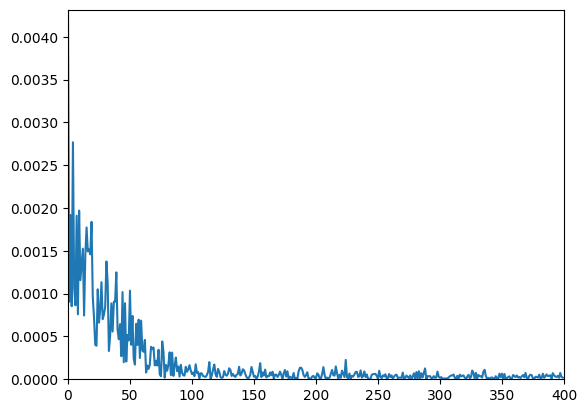

In [19]:
plt.plot(costs)
plt.ylim([0, max(costs)])
plt.xlim([0, 400])

### Working with DataSets and DataLoaders

Instead of manually batching the data, we can ask `torch` to handle it, and shuffle the datasets too. We start by defining a Dataset, which is a subclass of `torch.utils.data.Dataset` that implements `__getitem__` and `__len__`:

In [26]:
class RKDataSet(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        RKdata = pd.read_csv('RKwilson.dat', sep='\t', names=['C9', 'C10', 'RK'])
        self.X = torch.tensor(RKdata[['C9', 'C10']].values, dtype=torch.float32)
        self.Y = torch.tensor(RKdata['RK'].values, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [27]:
RKset = RKDataSet()

In [28]:
RKset[7]

(tensor([-0.4186,  0.0365]), tensor(0.8966))

We could use the DataSet to preprocess the data. For example, we could have returned $R_K-1$, or normalized the range of $C_9$ and $C_{10}$

Now we are going to split our dataset in two, one for training and one for validation. This split is necessary in order to check that the model "learns" (i.e generalizes, interpolates) correctly. And of course, we have to check it with more than one data point!

In [29]:
train_data, test_data = torch.utils.data.random_split(RKset, [0.8, 0.2])

In [30]:
len(train_data)

1600

We create DataLoaders that will divide our data in batches of 20 elements and shuffle them

In [34]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True)

In [39]:
NN = MyNet()
cost_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)

In [40]:
def train_loop():
    NN.train()
    for X, Y in train_dataloader:
        pred = NN(X).flatten()
        cost = cost_fn(pred, Y)

        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

def test_loop():
    NN.eval()
    num_batches = len(test_dataloader)
    total_cost = 0
    with torch.no_grad():
        for X, Y in test_dataloader:
            pred = NN(X).flatten()
            total_cost += cost_fn(pred, Y)
    total_cost /= num_batches
    print(f"Average cost: {total_cost:.4f}\n")


And we will perform the loops 10 times (10 epochs)

In [41]:
epochs = 10
for epoch in range(epochs):
    print(f"\nEpoch {epoch}\n----------------------\n")
    train_loop()
    test_loop()


Epoch 0
----------------------

Average cost: 0.0095


Epoch 1
----------------------

Average cost: 0.0023


Epoch 2
----------------------

Average cost: 0.0006


Epoch 3
----------------------

Average cost: 0.0004


Epoch 4
----------------------

Average cost: 0.0003


Epoch 5
----------------------

Average cost: 0.0002


Epoch 6
----------------------

Average cost: 0.0001


Epoch 7
----------------------

Average cost: 0.0001


Epoch 8
----------------------

Average cost: 0.0000


Epoch 9
----------------------

Average cost: 0.0000



In [42]:
NN(torch.tensor([-0.8, -0.3], dtype=torch.float32))

tensor([0.9127], grad_fn=<AddBackward0>)